# Top of Notebook: Assume that the classifier and regressor subcomponents have been trained

In [1]:
import pandas as pd
import numpy as np
import joblib
import importlib
import os
import pickle as pkl
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    f1_score, confusion_matrix, log_loss,
    mean_squared_error, root_mean_squared_error,
    mean_absolute_error, r2_score, mean_tweedie_deviance, mean_gamma_deviance,
    mean_absolute_percentage_error
)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Add project path
project_path = '/content/drive/My Drive/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

from tqdm import trange
from tqdm import tqdm
import pipeline_lgbm # for classifiers
import LGBMRegr_pipeline # for regressors
importlib.reload(pipeline_lgbm)
importlib.reload(LGBMRegr_pipeline)
print("loaded pipelines.")

import lightgbm as lgb
# Try a tiny dummy training on GPU to see if it crashes
try:
    lgb.LGBMClassifier(device='gpu', verbose=-1).fit([[0], [1]], [0, 1])
    print("GPU Acceleration is AVAILABLE.")
except Exception as e:
    print("GPU Acceleration is NOT available. Error:", e)


Mounted at /content/drive
loaded pipelines.
GPU Acceleration is AVAILABLE.


In [34]:
# --- CONFIGURATION ---
# Update these paths to your actual saved model files
lgbm_path = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/"
CLASS_MODEL_PATH = lgbm_path + "Binary Classification/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib"
# REGR_MODEL_PATH = lgbm_path + "Gamma Regression/LGBM_RegHurdle_GammaDec6_added_delay_20251207_000432.joblib"
REGR_MODEL_PATH = lgbm_path + "Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_044351.joblib"

# Test Data Paths
mod = "added_delay_20251202_034422" # or "1", "2" etc. for the smaller datasets
DATA_FILE_PATH = "/content/drive/My Drive/CIS 5200 Final Project/train_test_datasets/"
X_TEST_PATH = DATA_FILE_PATH + f'X_test_{mod}.csv'
Y_TEST_PATH = DATA_FILE_PATH + f'y_test_{mod}.csv'

# Targets
CLS_TARGET = 'DEP_DEL15'       # Binary (0/1)
REG_TARGET = 'DEP_ADDED_DELAY' # Continuous (Minutes)

# Small Surgery for the regression model which had a bad parameter

In [ ]:
pipeline_wrapper = joblib.load(REGR_MODEL_PATH)
model = pipeline_wrapper.model
# LightGBM stores extra/unknown parameters in the '_other_params' dictionary
if hasattr(model, '_other_params') and 'stopping_rounds' in model._other_params:
    print(f"Found bad parameter: {model._other_params['stopping_rounds']}")
    del model._other_params['stopping_rounds']
    print("Successfully removed 'stopping_rounds' from model configuration.")
else:
    print("Parameter not found in _other_params.")

Parameter not found in _other_params.


In [ ]:
model._other_params

{'verbose': 1, 'metric': ['gamma', 'mae', 'rmse', 'r2']}

In [ ]:
# # 3. Save it back
# joblib.dump(pipeline_wrapper, REGR_MODEL_PATH)
# print("Saved cleaned model.")

Saved cleaned model.


# Try to put model prediction pipelines on gpu

# Hurdle Model Definition

In [35]:
import gc

class HurdleModel:
    def __init__(self, classifier_path, regressor_path, device='gpu'):
        print(f"Loading Classifier: {classifier_path}...")
        self.clf_pipeline = joblib.load(classifier_path)

        self.clf_model = self.clf_pipeline.model

        print(f"Loading Regressor: {regressor_path}...")
        self.reg_pipeline = joblib.load(regressor_path)
        self.reg_model = self.reg_pipeline.model

        self.set_prediction_device(device)

    def set_prediction_device(self, device):
        """
        Allows changing the device for the underlying LightGBM models.
        Useful for switching between 'gpu' and 'cpu' after loading/unpickling.
        """
        print(f"Attempting to set prediction device to '{device}'...")
        if hasattr(self.clf_model, 'set_params'):
            self.clf_model.set_params(device=device)
            print(f"Classifier device set to: {self.clf_model.get_params().get('device')}")
        else:
            print("Classifier model does not support set_params for device configuration.")

        if hasattr(self.reg_model, 'set_params'):
            self.reg_model.set_params(device=device)
            print(f"Regressor device set to: {self.reg_model.get_params().get('device')}")
        else:
            print("Regressor model does not support set_params for device configuration.")

    def predict(self, X, threshold=0.5, method='expected', batch_size=50000):
        """
        Runs inference in batches to prevent RAM spikes/hanging.
        """
        n_samples = len(X)
        print(f"Starting batched inference on {n_samples} samples...")

        probs_list = []
        mags_list = []

        # Loop through data in chunks
        for i in trange(0, n_samples, batch_size):
            # 1. Slice the batch
            # Use .iloc to get a clean slice, .copy() to ensure no memory leakage
            batch = X.iloc[i : i + batch_size].copy()

            # --- CLASSIFIER (Probabilities) ---
            if hasattr(self.clf_pipeline, 'predict_proba'):
                # Standard Sklearn Pipeline
                p_batch = self.clf_pipeline.predict_proba(batch)[:, 1]
            else:
                # Custom InferencePipeline wrapper
                # We access the internal preprocessor/model manually to be safe
                batch_trans = self.clf_pipeline.preprocessor.transform(batch)
                p_batch = self.clf_pipeline.model.predict_proba(batch_trans)[:, 1]

            probs_list.append(p_batch)

            # --- REGRESSOR (Magnitudes) ---
            if hasattr(self.reg_pipeline, 'predict'):
                m_batch = self.reg_pipeline.predict(batch)
            else:
                batch_trans_reg = self.reg_pipeline.preprocessor.transform(batch)
                m_batch = self.reg_pipeline.model.predict(batch_trans_reg)

            mags_list.append(m_batch)

            # Progress Log
            if (i // batch_size) % 2 == 0:
                print(f"  Processed {min(i + batch_size, n_samples)} / {n_samples} rows...")

            # Clean up batch memory immediately
            del batch
            # If using custom transforms, clean those intermediate variables too
            if 'batch_trans' in locals(): del batch_trans
            if 'batch_trans_reg' in locals(): del batch_trans_reg
            gc.collect()

        print("Batching complete. Concatenating results...")

        # 2. Reassemble
        probs = np.concatenate(probs_list)
        magnitudes = np.concatenate(mags_list)

        # Safety: Ensure no negative predictions
        magnitudes = np.maximum(magnitudes, 0)

        # 3. Combine Logic
        if method == 'expected':
            return probs * magnitudes

        elif method == 'hard':
            mask = probs >= threshold
            final_preds = np.zeros_like(probs)
            final_preds[mask] = magnitudes[mask]
            return final_preds

        elif method == 'raw':
            return probs, magnitudes

print("Hurdle Model (Batched) Defined Successfully.")

Hurdle Model (Batched) Defined Successfully.


In [39]:
# 1. Instantiate the Combined Model (and Save it)
hurdle_model = HurdleModel(CLASS_MODEL_PATH, REGR_MODEL_PATH, device='gpu')
with open(lgbm_path + 'LGBMHurdle_BestClass_GammaRegr.pickle', 'wb') as f:
     pkl.dump(hurdle_model, f)

Loading Classifier: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib...
Loading Regressor: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_044351.joblib...
Attempting to set prediction device to 'gpu'...
Classifier device set to: gpu
Regressor device set to: gpu


In [11]:
hurdle_model.clf_pipeline

In [19]:
# 2. Load Test Data
print("Loading Test Data...")
X_test = pd.read_csv(X_TEST_PATH)
y_test_df = pd.read_csv(Y_TEST_PATH)

# Extract both targets
y_test_binary = y_test_df[CLS_TARGET]
y_test_value = y_test_df[REG_TARGET]

print(f"Test Data Loaded.")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test_binary.shape}")

Loading Test Data...
Test Data Loaded.
X_test Shape: (1271596, 49)
y_test Shape: (1271596,)


## Run Inference

In [29]:
# Generate Predictions
print("Running Inference...")

# 1. Get Component Predictions (for individual analysis)
probs, magnitudes = hurdle_model.predict(X_test, method='raw')

# 2. Get Combined Predictions (Expected Delay)
# This smoothes the output: A 50% chance of 20 mins = 10 mins expected delay
y_pred_expected = probs * magnitudes

# 3. Get Combined Predictions (Hard Decision @ 0.5 threshold)
# Either 0 mins OR the full regressor amount
y_pred_hard = np.where(probs >= 0.5, magnitudes, 0)

print("Inference Complete.")

Running Inference...
Inference Complete.


In [ ]:
a = pd.Series(y_pred_expected)

In [ ]:
a.describe()

,0
count,1.271596e+06
mean,3.907030e+00
std,1.118939e+01
min,5.675854e-05
25%,1.563352e-01
50%,5.362922e-01
75%,1.896529e+00
max,1.549329e+02


In [ ]:
len(probs)

1271596

# Compute and Save Performance and Predictions

In [23]:
SAVE_PREDICTIONS_PATH = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/"

In [ ]:
predictions = {'probs': probs, 'magnitudes': magnitudes,
               'y_pred_expected': y_pred_expected,
               'y_pred_hard': y_pred_hard,
               'y_test': y_test_value}

In [30]:

print("\n" + "="*30)
print("FULL HURDLE MODEL PERFORMANCE")
print("(Evaluated on ALL flights, including zeros)")
print("="*30)

# Evaluate 'Expected Value' predictions against True Values (which include 0s)
rmse_full = root_mean_squared_error(y_test_value, y_pred_expected)
mae_full = mean_absolute_error(y_test_value, y_pred_expected)
r2_full = r2_score(y_test_value, y_pred_expected)
tweedie_deviance_full = mean_tweedie_deviance(y_test_value, y_pred_expected, power=1.5)
mse_full = mean_squared_error(y_test_value, y_pred_expected)
# mape_full = mean_absolute_percentage_error(y_test_value, y_pred_expected)
print(f"RMSE (Full Dataset): {rmse_full:.4f} min")
print(f"MSE (Full Dataset):  {mse_full:.4f}")
print(f"MAE (Full Dataset):  {mae_full:.4f} min")
print(f"Mean Tweedie Deviance (Full Dataset):  {tweedie_deviance_full:.4f}")
# print(f"MAPE (Full Dataset):  {mape_full:.4f}")
print(f"R2 (Full Dataset):   {r2_full:.4f}")


FULL HURDLE MODEL PERFORMANCE
(Evaluated on ALL flights, including zeros)
RMSE (Full Dataset): 5.0859 min
MSE (Full Dataset):  25.8662
MAE (Full Dataset):  1.7225 min
Mean Tweedie Deviance (Full Dataset):  1.9583
R2 (Full Dataset):   0.9089


In [ ]:
performance = {'rmse': rmse_full, 'mae': mae_full, 'r2': r2_full, 'tweedie_deviance': tweedie_deviance_full}
predictions.update(performance)
predictions['CLASSIFIER_PATH'] = CLASS_MODEL_PATH
predictions['REGRESSOR_PATH'] = REGR_MODEL_PATH

### Save and Load Preds

In [ ]:
with open(SAVE_PREDICTIONS_PATH+"LightGBMHurdle_BestBinaryClass_GammaRegr_details.json", 'wb') as f:
      pkl.dump(predictions, f)

In [24]:
with open(SAVE_PREDICTIONS_PATH+"LightGBMHurdle_BestBinaryClass_GammaRegr_details.json", 'rb') as f:
      load_preds = pkl.load(f)

# with open(SAVE_PREDICTIONS_PATH+"LightGBMHurdle_BinaryClass_GammaRegr_predictions_and_metrics.json", 'rb') as f:
#   load_preds = pkl.load(f)

In [ ]:
load_preds

{'probs': array([0.0556155 , 0.08357938, 0.01320192, ..., 0.01358746, 0.00331784,
        0.00392304]),
 'magnitudes': array([5.27104985, 4.01157434, 8.01246946, ..., 2.30685022, 5.15016355,
        0.7877008 ]),
 'y_pred_expected': array([0.29315205, 0.33528488, 0.10577999, ..., 0.03134424, 0.0170874 ,
        0.00309018]),
 'y_pred_hard': array([0., 0., 0., ..., 0., 0., 0.]),
 'y_test': 0          0
 1          0
 2          0
 3          0
 4          0
           ..
 1271591    0
 1271592    0
 1271593    0
 1271594    0
 1271595    0
 Name: DEP_ADDED_DELAY, Length: 1271596, dtype: int64,
 'rmse': 4.916117375874207,
 'mae': 1.6597144247208535,
 'r2': 0.9148771011149414,
 'tweedie_deviance': 1.957087889632299,
 'CLASSIFIER_PATH': '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib',
 'REGRESSOR_PATH': '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGB

## Plot AUC-ROC

In [ ]:
y_prob = load_preds['probs']

In [ ]:
print(len(y_prob))
print(len(y_test_binary))

1271596
1271596


0.9810647108812349


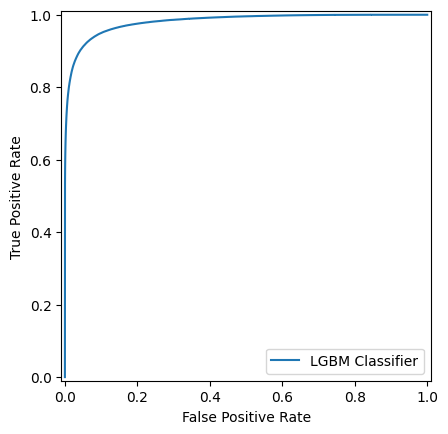

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# 1. Get Probabilities (if you haven't already)
# Ensure you are getting the probability of the POSITIVE class (1)
# y_prob should be an array of floats like [0.12, 0.88, 0.45, ...]
if 'y_prob' not in locals():
    # Assuming 'hurdle_model' or 'loaded_pipeline' is your model object
    # y_prob = hurdle_model.clf_pipeline.predict_proba(X_test)[:, 1]
    pass # Replace with your actual prediction code if needed

# 2. Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
curve = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name = 'LGBM Classifier', pos_label=None)
curve.plot()
roc_auc = roc_auc_score(y_test_binary, y_prob)
print(roc_auc)
# roc_auc = auc(fpr, tpr)

# # 3. Plot
# plt.figure(figsize=(10, 8))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# # Aesthetics
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
# plt.ylabel('True Positive Rate (Sensitivity / Recall)', fontsize=12)
# plt.title('Receiver Operating Characteristic (ROC) - LightGBM Classifier', fontsize=14)
# plt.legend(loc="lower right", fontsize=12)
# plt.grid(True, alpha=0.3)

# plt.show()